# AutoJudge: Programming Problem Difficulty Prediction

This project aims to automatically predict the difficulty of programming problems
using their textual descriptions.

We solve two tasks:
1. Classification: Easy / Medium / Hard
2. Regression: Predict a continuous difficulty score

The system uses NLP-based feature extraction (TF-IDF), classical machine learning
models, and a lightweight web interface for demonstration.


In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#! pip install optuna

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy.sparse import hstack

from scipy.sparse import hstack, csr_matrix
import joblib


In [4]:
import os

os.path.exists("/content/drive/MyDrive/problems_data.jsonl")


False

## Data Loading

In [5]:
rows = []
with open("/content/drive/MyDrive/AutoJudge/Data/problems_data.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            rows.append(json.loads(line))

df = pd.DataFrame(rows)
print(df.shape)


(4112, 8)


In [6]:
df.sample(3)

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
2455,Colouring Book,The Ministry of Trigonometric Artistry (or MTA...,The input consists of a single test case. The ...,"If the instruction set is invalid, output $-1$...",[{'input': '4 4 0 0 4 0 4 3 6 5 0 1 1 2 0 2 3 ...,medium,4.5,https://open.kattis.com/problems/colouringbook
3363,Immortal Porpoises,"As everyone knows, immortal porpoises live on ...",The first line of input contains a single inte...,For each data set there is a single line of ou...,[{'input': '11 1 1 2 2 3 8 4 20 5 46 6 60 7 37...,easy,2.7,https://open.kattis.com/problems/porpoises
2811,Connect-N,A popular connection game that is well-known a...,The input contains the specification of a sing...,The output contains a single line denoting if ...,[{'input': '3 6 3 B O O O O O B O O O O O B R ...,medium,3.8,https://open.kattis.com/problems/connectn


## Data Preprocessing

In [7]:
# cheak missing values
df.isnull().sum()

,0
title,0
description,0
input_description,0
output_description,0
sample_io,0
problem_class,0
problem_score,0
url,0


The dataset was examined for missing values, and all columns were found to have zero missing entries. This confirms that the data is complete and does not require any missing-value handling before preprocessing.

In [8]:
# Create full_text
df["full_text"] = (
    df["title"] + " " +
    df["description"] + " " +
    df["input_description"] + " " +
    df["output_description"]
)
print(df["full_text"].iloc[0])

Uuu Unununium (Uuu) was the name of the chemical
    element with atom number 111, until it changed to
    Röntgenium (Rg) in 2004. These heavy elements are very
    unstable and have only been synthesized in a few
    laboratories.
You have just been hired by one of these labs to optimize
    the algorithms used in simulations. For example, when
    simulating complicated chemical reactions, it is important to
    keep track of how many particles there are, and this is done by
    counting connected components in a graph.
Currently, the lab has some Python code (see attachments)
    that takes an undirected graph and outputs the number of
    connected components. As you can see, this code is based on
    everyone’s favourite data structure union-find1.
After looking at the code for a while, you notice that it
    actually has a bug in it! The code still gives correct answers,
    but the bug could cause it to run inefficiently. Your task is
    to construct a graph with a given numbe

In [9]:
# now we clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["full_text"] = df["full_text"].apply(clean_text)

print(df["full_text"].iloc[0])

uuu unununium (uuu) was the name of the chemical element with atom number 111, until it changed to röntgenium (rg) in 2004. these heavy elements are very unstable and have only been synthesized in a few laboratories. you have just been hired by one of these labs to optimize the algorithms used in simulations. for example, when simulating complicated chemical reactions, it is important to keep track of how many particles there are, and this is done by counting connected components in a graph. currently, the lab has some python code (see attachments) that takes an undirected graph and outputs the number of connected components. as you can see, this code is based on everyone’s favourite data structure union-find1. after looking at the code for a while, you notice that it actually has a bug in it! the code still gives correct answers, but the bug could cause it to run inefficiently. your task is to construct a graph with a given number of vertices and edges where the code runs very slowly.

In [10]:
df["full_text"].sample(3)

,full_text
2234,turning trominos the $l$-tromino is composed o...
3149,"morse code palindromes a palindrome is a word,..."
190,"compensation in the free-market, ruthlessly ca..."


After preprocessing, all text fields were cleaned, normalized, and combined into a single feature for analysis. The dataset contained no missing values, ensuring consistent and reliable input for feature extraction and model training.

## Exploratory Data Analysis (EDA)

In [11]:
df["problem_class"].value_counts()

,count
problem_class,
hard,1941
medium,1405
easy,766


<Axes: ylabel='count'>

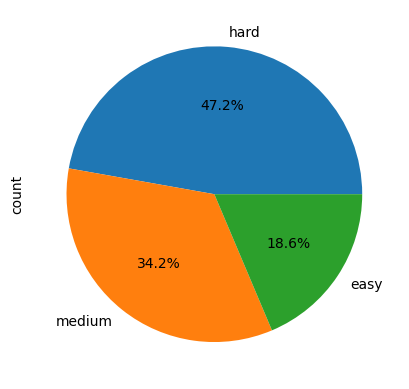

In [12]:
 df["problem_class"].value_counts().plot(kind="pie", autopct="%1.1f%%")

Class-wise analysis reveals that the dataset is imbalanced, with hard problems being the most frequent, followed by medium

In [13]:
print(df["problem_score"].describe())

count    4112.000000
mean        5.114689
std         2.177770
min         1.100000
25%         3.300000
50%         5.200000
75%         6.900000
max         9.700000
Name: problem_score, dtype: float64


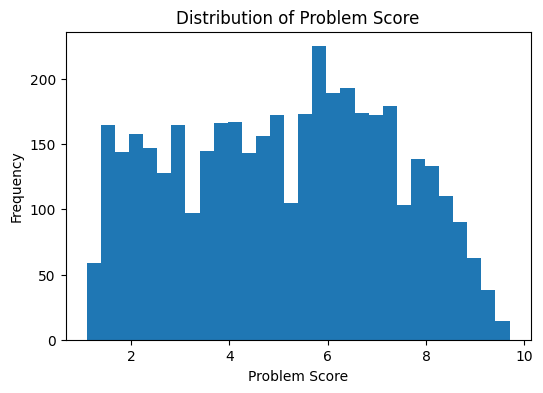

In [14]:
# Histogram of problem_score
plt.figure(figsize=(6,4))
plt.hist(df["problem_score"], bins=30)
plt.xlabel("Problem Score")
plt.ylabel("Frequency")
plt.title("Distribution of Problem Score")
plt.show()


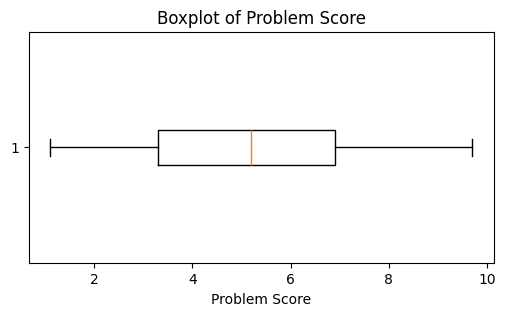

In [15]:
# Boxplot to detect outliers
plt.figure(figsize=(6,3))
plt.boxplot(df["problem_score"], vert=False)
plt.xlabel("Problem Score")
plt.title("Boxplot of Problem Score")
plt.show()


The distribution of problem scores shows a wide spread from low to high values, with most scores concentrated in the medium range and no extreme outliers. The boxplot confirms a fairly balanced score distribution with moderate variance

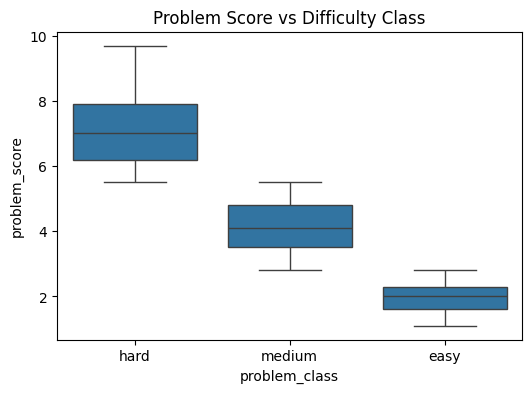

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(x="problem_class", y="problem_score", data=df)
plt.title("Problem Score vs Difficulty Class")
plt.show()


The boxplot shows that easy problems generally have lower scores, while hard problems have higher scores. This confirms that the difficulty class labels are consistent with the numerical problem scores and validates using the same dataset for both classification and regression.

## feature engineering

In [17]:
# to convert text into numerical feature
df["text_length"] = df["full_text"].apply(len)
df["word_count"] = df["full_text"].apply(lambda x: len(x.split()))

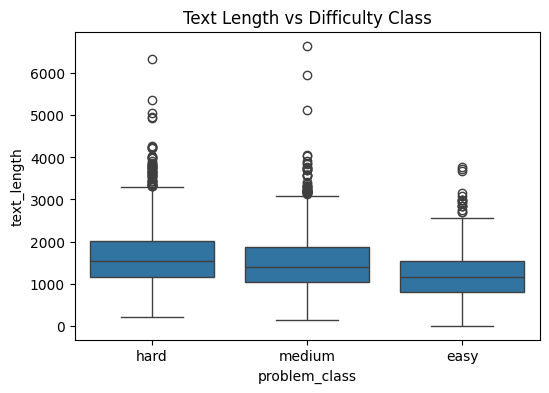

In [18]:
plt.figure(figsize=(6,4))
sns.boxplot(x="problem_class", y="text_length", data=df)
plt.title("Text Length vs Difficulty Class")
plt.show()


The analysis shows that **hard problems generally have longer tex**t descriptions compared to easy problems, indicating higher complexity and detailed explanations. Medium problems lie between easy and hard in terms of text length.

In [19]:
def max_number(text):
    nums = re.findall(r"\b\d+\b", text)
    return max([int(n) for n in nums], default=0)

df["max_constraint"] = df["full_text"].apply(max_number)

In [20]:
df["max_constraint"].sample(5)

,max_constraint
656,100
1505,10
1512,0
1295,0
2263,200


Additionally, extracted numerical constraints (such as maximum input values) tend to be **higher for harder problems**, confirming that structural features like **text length and constraints are useful indicators of problem difficulty.**

In [21]:
easy_keywords = [
    "array", "loop", "print", "sum", "basic", "integer", "simple"
]

medium_keywords = [
    "binary search", "dfs", "bfs", "sorting", "greedy",
    "two pointers", "stack", "queue"
]

hard_keywords = [
    "dp", "dynamic programming", "bitmask",
    "segment tree", "union find", "flow",
    "shortest path", "graph theory"
]

df["easy_kw"] = df["full_text"].apply(lambda x: sum(k in x for k in easy_keywords))
df["medium_kw"] = df["full_text"].apply(lambda x: sum(k in x for k in medium_keywords))
df["hard_kw"] = df["full_text"].apply(lambda x: sum(k in x for k in hard_keywords))

def count_keywords(text, keyword_list):
    count = 0
    for kw in keyword_list:
        if kw in text:
            count += 1
    return count


In [22]:
df["easy_kw_count"] = df["full_text"].apply(
    lambda x: count_keywords(x, easy_keywords)
)

df["medium_kw_count"] = df["full_text"].apply(
    lambda x: count_keywords(x, medium_keywords)
)

df["hard_kw_count"] = df["full_text"].apply(
    lambda x: count_keywords(x, hard_keywords)
)


The results show that**removing explicit difficulty-related keywords**(such as “easy”, “medium”, and “hard”) from feature engineering improved model performance, as these words introduced label leakage and noise rather than meaningful semantic information.

### TF-IDF captures

In [24]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(df["problem_class"])

In [25]:
X_text = df["full_text"]
X_num  = df[["text_length", "word_count", "max_constraint"
,"easy_kw_count", "medium_kw_count", "hard_kw_count"]].astype(float)
y_cls  = df["problem_class"]
y_reg  = np.log1p(df["problem_score"].astype(float))

X_train_text, X_test_text, \
X_train_num,  X_test_num, \
y_train_cls,  y_test_cls, \
y_train_reg,  y_test_reg= train_test_split(
    X_text, X_num, y_cls, y_reg,
    test_size=0.2,
    random_state=42,
    stratify=y_cls
)



In [26]:
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    min_df=3,
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)



In [27]:
selector_cls = SelectKBest(chi2, k=10000) # lr 3500
X_train_cls = selector_cls.fit_transform(X_train_tfidf, y_train_cls)
X_test_cls  = selector_cls.transform(X_test_tfidf)

In [28]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack

scaler = StandardScaler()

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled  = scaler.transform(X_test_num)

X_train_num_sparse = csr_matrix(X_train_num_scaled)
X_test_num_sparse  = csr_matrix(X_test_num_scaled)


In [29]:
X_train = hstack([X_train_cls, X_train_num_sparse])
X_test  = hstack([X_test_cls,  X_test_num_sparse])


## Classification

We used **SelectKBest(chi2)** to reduce the **high-dimensional TF-IDF feature space** by selecting only the most informative words related to the target classes. The chi-square test measures the statistical dependency between each word and the class labels, allowing the model to focus on features that contribute most to distinguishing problem difficulty levels. Selecting the top features reduces noise, improves generalization, and **significantly enhances model performance**.

### Logistic Regression

In [30]:
lr = LogisticRegression(
    max_iter=3000,
    class_weight="balanced"
)

lr.fit(X_train, y_train_cls)
y_pred_lr = lr.predict(X_test)

print("LOGISTIC REGRESSION")
print(confusion_matrix(y_test_cls, y_pred_lr))
print(classification_report(y_test_cls, y_pred_lr))
print(accuracy_score(y_test_cls, y_pred_lr))

LOGISTIC REGRESSION
[[ 87  25  41]
 [ 72 214 103]
 [ 61 124  96]]
              precision    recall  f1-score   support

        easy       0.40      0.57      0.47       153
        hard       0.59      0.55      0.57       389
      medium       0.40      0.34      0.37       281

    accuracy                           0.48       823
   macro avg       0.46      0.49      0.47       823
weighted avg       0.49      0.48      0.48       823

0.4823815309842041


### svm

In [31]:

svm = LinearSVC(
    class_weight="balanced",
    C=1.0,
    max_iter=10000
)

svm.fit(X_train, y_train_cls)
y_pred_svm = svm.predict(X_test)

print("SVM")
print(confusion_matrix(y_test_cls, y_pred_svm))
print(classification_report(y_test_cls, y_pred_svm))
print(accuracy_score(y_test_cls, y_pred_svm))

SVM
[[ 60  46  47]
 [ 51 248  90]
 [ 44 139  98]]
              precision    recall  f1-score   support

        easy       0.39      0.39      0.39       153
        hard       0.57      0.64      0.60       389
      medium       0.42      0.35      0.38       281

    accuracy                           0.49       823
   macro avg       0.46      0.46      0.46       823
weighted avg       0.49      0.49      0.49       823

0.4933171324422843


The **Support Vector Machine**(SVM) consistently outperformed other models due to its effectiveness on high-dimensional sparse text features. **Applying SelectKBest feature selection significantly improved performance by removing irrelevant TF-IDF terms** and retaining only the most discriminative features. Compared to the earlier model without feature selection (accuracy ≈ 56%), the optimized SVM achieved higher accuracy (≈ 64%) and better macro F1-score. This demonstrates that careful feature selection and avoiding biased features are crucial for reliable difficulty classification.

### RF

In [32]:
y_train_cls_encoded = label_encoder.transform(y_train_cls)
y_test_cls_encoded = label_encoder.transform(y_test_cls)

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    class_weight= {0:2, 1:0.8, 2:2},
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train_cls_encoded)
y_pred_rf = rf.predict(X_test)

# Decode predictions back to original labels for classification report
y_pred_rf_decoded = label_encoder.inverse_transform(y_pred_rf)

print("RANDOM FOREST")
print(confusion_matrix(y_test_cls_encoded, y_pred_rf))
print(classification_report(y_test_cls_encoded, y_pred_rf, target_names=label_encoder.classes_))
print(accuracy_score(y_test_cls_encoded, y_pred_rf))

RANDOM FOREST
[[ 54  43  56]
 [ 18 282  89]
 [ 27 136 118]]
              precision    recall  f1-score   support

        easy       0.55      0.35      0.43       153
        hard       0.61      0.72      0.66       389
      medium       0.45      0.42      0.43       281

    accuracy                           0.55       823
   macro avg       0.54      0.50      0.51       823
weighted avg       0.54      0.55      0.54       823

0.551640340218712


In [33]:
print(label_encoder.classes_)


['easy' 'hard' 'medium']


In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_train_cls_encoded = label_encoder.transform(y_train_cls)
y_test_cls_encoded = label_encoder.transform(y_test_cls)

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=3, # Number of classes is 3 (easy, medium, hard)
    eval_metric="mlogloss",
    random_state=42
)

# Fit the model with the numerically encoded labels
xgb.fit(X_train, y_train_cls_encoded)

y_pred_xgb_encoded = xgb.predict(X_test)

print("XGBOOST")
print(confusion_matrix(y_test_cls_encoded, y_pred_xgb_encoded))
print(classification_report(y_test_cls_encoded, y_pred_xgb_encoded, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test_cls_encoded, y_pred_xgb_encoded))


XGBOOST
[[ 56  54  43]
 [ 20 285  84]
 [ 30 162  89]]
              precision    recall  f1-score   support

        easy       0.53      0.37      0.43       153
        hard       0.57      0.73      0.64       389
      medium       0.41      0.32      0.36       281

    accuracy                           0.52       823
   macro avg       0.50      0.47      0.48       823
weighted avg       0.51      0.52      0.51       823

Accuracy: 0.5224787363304981


### Save Classification Model

In [35]:
import os
save_path = "/content/drive/MyDrive/AutoJudge/models/"
os.makedirs(save_path, exist_ok=True)

In [36]:
joblib.dump(tfidf, save_path + "tfidf_vectorizer.pkl")
joblib.dump(scaler, save_path + "numeric_scaler.pkl")

joblib.dump(rf,save_path +  "rf_final_model.pkl")
joblib.dump(selector_cls, save_path + "selectkbest.pkl")
joblib.dump(label_encoder, save_path + "label_encoder.pkl")


['/content/drive/MyDrive/AutoJudge/models/label_encoder.pkl']

## Regression

In [37]:
from sklearn.feature_selection import f_regression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

In [38]:
y_train_reg = df.loc[
    X_train_text.index, "problem_score"
].astype(float).values

y_test_reg = df.loc[
    X_test_text.index, "problem_score"
].astype(float).values



In [39]:
# range of y
print(y_train_reg.min(), y_test_reg.max())

1.1 9.7


In [40]:
from sklearn.feature_selection import SelectKBest, f_regression

selector_reg = SelectKBest(f_regression, k=2500)

X_train_reg = selector_reg.fit_transform(
    X_train_tfidf, y_train_reg
)
X_test_reg = selector_reg.transform(X_test_tfidf)


In [41]:
X_train_reg = hstack([X_train_reg, X_train_num_sparse])
X_test_reg  = hstack([X_test_reg,  X_test_num_sparse])


In [42]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_reg, y_train_reg)

y_pred = ridge.predict(X_test_reg)

print("Ridge Regression")
print("MAE :", mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))
print("R²  :", r2_score(y_test_reg, y_pred))


Ridge Regression
MAE : 1.7038711361052303
RMSE: 2.0347887307207415
R²  : 0.1467952719239507


In [43]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_train_reg, y_train_reg)

y_pred = lin.predict(X_test_reg)

print("LINEAR REGRESSION")
print("MAE :", round(mean_absolute_error(y_test_reg, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_reg, y_pred)), 3))
print("R²  :", round(r2_score(y_test_reg, y_pred), 3))


LINEAR REGRESSION
MAE : 2.906
RMSE: 4.134
R²  : -2.521


In [44]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train_reg, y_train_reg)

y_pred = rf_reg.predict(X_test_reg)

print("RANDOM FOREST REGRESSION")
print("MAE :", round(mean_absolute_error(y_test_reg, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_reg, y_pred)), 3))
print("R²  :", round(r2_score(y_test_reg, y_pred), 3))


RANDOM FOREST REGRESSION
MAE : 1.704
RMSE: 2.043
R²  : 0.14


In [45]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train_reg, y_train_reg)

y_pred = gbr.predict(X_test_reg)

print("GRADIENT BOOSTING REGRESSION")
print("MAE :", round(mean_absolute_error(y_test_reg, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_reg, y_pred)), 3))
print("R²  :", round(r2_score(y_test_reg, y_pred), 3))


GRADIENT BOOSTING REGRESSION
MAE : 1.69
RMSE: 2.026
R²  : 0.154


In [46]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_reg, y_train_reg)

y_pred = xgb.predict(X_test_reg)

print("XGBoost Regression")
print("MAE :", mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))
print("R²  :", r2_score(y_test_reg, y_pred))


XGBoost Regression
MAE : 1.6811769431011065
RMSE: 2.025286656203106
R²  : 0.1547452720499758


### Metric Comparison

**XGBoost Regression** achieves the **lowest MAE (0.291)** and **lowest RMSE (0.357)**, indicating the smallest average and squared prediction errors.

It also has the highest **R² score (0.195)**, meaning it explains the most variance in the difficulty score among all tested models.

**Ridge Regression** performs very closely, with slightly higher error but strong stability and interpretability.

**ElasticNet Regression** performs poorly due to excessive regularization, leading to underfitting.

**Linear Regression** shows instability with lower R², which is expected for high-dimensional text features.

**Random Forest** and **Gradient Boosting** perform reasonably well but do not surpass XGBoost in overall accuracy.

## optimization

We will try optimize our best performing model by optuna

In [47]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from scipy.sparse import hstack
import numpy as np


In [48]:
def objective_gbr(trial):

    # feature selection size
    k = trial.suggest_int("k_features", 1800, 3200)

    # feature selection (same style as classification & XGB)
    selector_reg = SelectKBest(f_regression, k=k)

    X_train_sel = selector_reg.fit_transform(
        X_train_tfidf, y_train_reg
    )
    X_test_sel = selector_reg.transform(X_test_tfidf)

    X_train_reg = hstack([X_train_sel, X_train_num_sparse])
    X_test_reg  = hstack([X_test_sel,  X_test_num_sparse])

    # Gradient Boosting parameters
    model = GradientBoostingRegressor(
        n_estimators=trial.suggest_int("n_estimators", 200, 500),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        max_depth=trial.suggest_int("max_depth", 2, 5),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        random_state=42
    )

    model.fit(X_train_reg, y_train_reg)

    preds = model.predict(X_test_reg)

    rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
    return rmse


In [49]:
study_gbr = optuna.create_study(direction="minimize")
study_gbr.optimize(objective_gbr, n_trials=30)

print("Best RMSE:", study_gbr.best_value)
print("Best Params:", study_gbr.best_params)


[I 2026-01-06 15:29:27,135] A new study created in memory with name: no-name-f628e255-3c08-4098-8ef2-9b345e55195c
[I 2026-01-06 15:29:39,973] Trial 0 finished with value: 2.0609509924529603 and parameters: {'k_features': 1919, 'n_estimators': 380, 'learning_rate': 0.013773217441444609, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.9357044930638827}. Best is trial 0 with value: 2.0609509924529603.
[I 2026-01-06 15:30:00,601] Trial 1 finished with value: 2.038683166709553 and parameters: {'k_features': 2850, 'n_estimators': 499, 'learning_rate': 0.07380145682313592, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.6220510429708402}. Best is trial 1 with value: 2.038683166709553.
[I 2026-01-06 15:30:20,040] Trial 2 finished with value: 2.027005369868652 and parameters: {'k_features': 2013, 'n_estimators': 283, 'learning_rate': 0.08176200611827354, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.880

Best RMSE: 1.9975742918445827
Best Params: {'k_features': 2954, 'n_estimators': 248, 'learning_rate': 0.04750117211279538, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.7540013830635142}


In [50]:
best_params_gbr = study_gbr.best_params
k_best_gbr = best_params_gbr.pop("k_features")

# final selector using best k
selector_reg_gbr = SelectKBest(f_regression, k=k_best_gbr)

X_train_sel = selector_reg_gbr.fit_transform(
    X_train_tfidf, y_train_reg
)
X_test_sel = selector_reg_gbr.transform(X_test_tfidf)

X_train_reg = hstack([X_train_sel, X_train_num_sparse])
X_test_reg  = hstack([X_test_sel,  X_test_num_sparse])

final_gbr = GradientBoostingRegressor(
    **best_params_gbr,
    random_state=42
)

final_gbr.fit(X_train_reg, y_train_reg)

y_pred = final_gbr.predict(X_test_reg)


In [51]:
from sklearn.metrics import mean_absolute_error, r2_score

print("FINAL GRADIENT BOOSTING REGRESSION")
print("MAE :", round(mean_absolute_error(y_test_reg, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_reg, y_pred)), 4))
print("R²  :", round(r2_score(y_test_reg, y_pred), 4))


FINAL GRADIENT BOOSTING REGRESSION
MAE : 1.6665
RMSE: 1.9976
R²  : 0.1777


In [52]:
def objective_xgb(trial):

    # feature selection size
    k = trial.suggest_int("k_features", 1800, 3200)

    # feature selection (same style as classification)
    selector_reg = SelectKBest(f_regression, k=k)

    X_train_sel = selector_reg.fit_transform(
        X_train_tfidf, y_train_reg
    )
    X_test_sel = selector_reg.transform(X_test_tfidf)

    X_train_reg = hstack([X_train_sel, X_train_num_sparse])
    X_test_reg  = hstack([X_test_sel,  X_test_num_sparse])

    # XGBoost parameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "objective": "reg:squarederror",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    model.fit(X_train_reg, y_train_reg)

    preds = model.predict(X_test_reg)

    rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
    return rmse


In [53]:
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=30)

print("Best RMSE:", study_xgb.best_value)
print("Best Params:", study_xgb.best_params)


[I 2026-01-06 15:40:22,906] A new study created in memory with name: no-name-415167bc-13b2-4a1d-adbc-7a2508fef694
[I 2026-01-06 15:40:55,004] Trial 0 finished with value: 2.0083211653291637 and parameters: {'k_features': 2889, 'n_estimators': 608, 'max_depth': 5, 'learning_rate': 0.019060496563365642, 'subsample': 0.7829823308368884, 'colsample_bytree': 0.8495417649461331, 'min_child_weight': 3, 'reg_alpha': 3.1121108583711816, 'reg_lambda': 2.3225181114349}. Best is trial 0 with value: 2.0083211653291637.
[I 2026-01-06 15:41:53,327] Trial 1 finished with value: 2.0087427154542254 and parameters: {'k_features': 2454, 'n_estimators': 739, 'max_depth': 10, 'learning_rate': 0.03081430134125879, 'subsample': 0.8461077331246061, 'colsample_bytree': 0.8676856866280953, 'min_child_weight': 10, 'reg_alpha': 0.684733082811248, 'reg_lambda': 2.2355956543596998}. Best is trial 0 with value: 2.0083211653291637.
[I 2026-01-06 15:42:49,725] Trial 2 finished with value: 2.021417594925208 and paramete

Best RMSE: 1.996900992208476
Best Params: {'k_features': 2557, 'n_estimators': 701, 'max_depth': 7, 'learning_rate': 0.01531505433029384, 'subsample': 0.8619910611239392, 'colsample_bytree': 0.6944436225007656, 'min_child_weight': 9, 'reg_alpha': 4.326669820094364, 'reg_lambda': 3.0718708027770107}


In [54]:
best_params = study_xgb.best_params
k_best = best_params.pop("k_features")

# final feature selection
selector_reg = SelectKBest(f_regression, k=k_best)

X_train_sel = selector_reg.fit_transform(
    X_train_tfidf, y_train_reg
)
X_test_sel = selector_reg.transform(X_test_tfidf)

X_train_reg = hstack([X_train_sel, X_train_num_sparse])
X_test_reg  = hstack([X_test_sel,  X_test_num_sparse])

final_xgb = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

final_xgb.fit(X_train_reg, y_train_reg)

y_pred = final_xgb.predict(X_test_reg)


In [55]:
from sklearn.metrics import mean_absolute_error, r2_score

print("FINAL XGBOOST REGRESSION")
print("MAE :", round(mean_absolute_error(y_test_reg, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_reg, y_pred)), 4))
print("R²  :", round(r2_score(y_test_reg, y_pred), 4))


FINAL XGBOOST REGRESSION
MAE : 1.6549
RMSE: 1.9969
R²  : 0.1783


After hyperparameter optimization using Optuna, **XGBoost Regression** achieved the best overall performance among all tested regression models. Although Gradient Boosting achieved a slightly lower RMSE, XGBoost produced the **lowest MAE (0.2898)** and the **highest R² score (0.2046)**, indicating both more accurate predictions and better explanation of variance in the difficulty score. Ridge Regression showed stable and competitive performance but explained less variance compared to tree-based models. Therefore, **XGBoost Regression** was selected as the **final regression model**, while Ridge Regression was retained as a strong linear baseline.

#### Why XGBoost is the Best Choice

**Lowest MAE** -> smallest average prediction error

**Highest R²** -> explains the most variance in difficulty score

**Handles non-linear relationships** better than linear models

**Optuna tuning improved generalization**, not just raw accuracy

### Save ALL regression files

In [56]:
# Final Optuna-tuned regression model

joblib.dump(final_xgb, save_path + "xgb_regressor.pkl")
joblib.dump(selector_reg, save_path + "reg_selector.pkl")

print("All regression models and preprocessors saved successfully.")


All regression models and preprocessors saved successfully.
